In [1]:
import socket
import struct
import numpy as np
import time
import matplotlib
from matplotlib import pyplot as plt
import glob, os

In [2]:
computer_path = '/Users/HHG'
data_path = computer_path + '/FilesRepositories'
plot_path = data_path + '/Project/DirectionSelectivity/'

tdrDir = '/Users/HHG/FilesRepositories/AEDAT/MovingBar/'
dataDir = tdrDir
os.chdir(dataDir)

dataList = glob.glob("*.aedat")
dataListRead = []
for i in dataList:
    dataListRead.append(open(i,"rb"))
    debug = False
    
#print dataListRead

In [3]:
def read_events(file):
    """ A simple function that read dynap-se events from cAER aedat 3.0 file format"""
    
    # raise Exception at end of file
    data = file.read(28)
    if(len(data) <= 0):
        print("read all data\n")
        raise NameError('END OF DATA')


    # read header
    eventtype = struct.unpack('H', data[0:2])[0]
    eventsource = struct.unpack('H', data[2:4])[0]
    eventsize = struct.unpack('I', data[4:8])[0]
    eventoffset = struct.unpack('I', data[8:12])[0]
    eventtsoverflow = struct.unpack('I', data[12:16])[0]
    eventcapacity = struct.unpack('I', data[16:20])[0]
    eventnumber = struct.unpack('I', data[20:24])[0]
    eventvalid = struct.unpack('I', data[24:28])[0]
    next_read = eventcapacity * eventsize  # we now read the full packet
    data = file.read(next_read)    
    counter = 0  # eventnumber[0]
    #spike events
    core_id_tot = []
    chip_id_tot = []
    neuron_id_tot = []
    ts_tot =[]
    #special events
    spec_type_tot =[]
    spec_ts_tot = []

    if(eventtype == 0):
        spec_type_tot =[]
        spec_ts_tot = []
        while(data[counter:counter + eventsize]):  # loop over all event packets
            special_data = struct.unpack('I', data[counter:counter + 4])[0]
            timestamp = struct.unpack('I', data[counter + 4:counter + 8])[0]
            spec_type = (special_data >> 1) & 0x0000007F
            spec_type_tot.append(spec_type)
            spec_ts_tot.append(timestamp)
            if(spec_type == 6 or spec_type == 7 or spec_type == 9 or spec_type == 10):
                print (timestamp, spec_type)
            counter = counter + eventsize        
    elif(eventtype == 12):
        while(data[counter:counter + eventsize]):  # loop over all event packets
            aer_data = struct.unpack('I', data[counter:counter + 4])[0]
            timestamp = struct.unpack('I', data[counter + 4:counter + 8])[0]
            core_id = (aer_data >> 1) & 0x0000001F
            chip_id = (aer_data >> 6) & 0x0000003F
            neuron_id = (aer_data >> 12) & 0x000FFFFF
            core_id_tot.append(core_id)
            chip_id_tot.append(chip_id)
            neuron_id_tot.append(neuron_id)
            ts_tot.append(timestamp)
            counter = counter + eventsize
            if(debug):          
                print("chip id "+str(chip_id)+'\n')
                print("core_id "+str(core_id)+'\n')
                print("neuron_id "+str(neuron_id)+'\n')
                print("timestamp "+str(timestamp)+'\n')
                print("####\n")


    return core_id_tot, chip_id_tot, neuron_id_tot, ts_tot, spec_type_tot, spec_ts_tot

In [4]:
def skip_header(file):
    ''' This function skip the standard header of the recording file '''
    line = file.readline()
    while line.startswith("#"):
        if ( line == '#!END-HEADER\r\n'):
            break
        else:
            line = file.readline()

In [5]:
done_reading = [False,False,False,False,False,False]

for data in dataListRead:
    skip_header(data)
    
datareadlist = dataListRead
spikes_left_1s = []
spikes_right_1s = []
spikes_left_3s = []
spikes_right_3s = []
spikes_left_5s = []
spikes_right_5s = []
times = []
neuron_17 = []

for i in range(len(dataListRead)):
    chip_id_tot = []
    core_id_tot = []
    neuron_id_tot = []
    ts_tot  = []
    spec_type_tot = []
    spec_ts_tot = []
    while(done_reading[i] == False):
        try:
            core_id, chip_id, neuron_id, ts, spec_type, spec_ts = read_events(dataListRead[i])
            core_id_tot.extend(np.array(core_id))
            chip_id_tot.extend(np.array(chip_id))
            neuron_id_tot.extend(np.array(neuron_id))
            ts_tot.extend(np.array(ts))
            spec_type_tot.extend(np.array(spec_type))
            spec_ts_tot.extend(np.array(spec_ts))
                
        except NameError:
                dataListRead[i].close()
                done_reading[i] = True
    neuron_id_d = []
    ts_id_d = []
    for chip, core, neur, ts in zip(chip_id_tot, core_id_tot, neuron_id_tot, ts_tot):
        if chip == 1 and core == 2:
            neuron_id_d.append(neur)
            ts_id_d.append(ts)
    times.append(ts_tot[-1]-ts_tot[0])
    neuron_17.append(neuron_id_d.count(17))
    spikes = np.array(neuron_id_d)
    indx_spikes = np.where(np.transpose(spikes)==17)[0]
    if (i == 0):
        for ind in indx_spikes:
            spikes_left_1s.append(ts_id_d[ind])
    elif (i == 1):
        for ind in indx_spikes:
            spikes_right_1s.append(ts_id_d[ind])
    elif (i == 2):
        for ind in indx_spikes:
            spikes_left_3s.append(ts_id_d[ind])
    elif (i == 3):
        for ind in indx_spikes:
            spikes_right_3s.append(ts_id_d[ind])
    elif (i == 4):
        for ind in indx_spikes:
            spikes_left_5s.append(ts_id_d[ind])
    elif (i == 5):
        for ind in indx_spikes:
            spikes_right_5s.append(ts_id_d[ind])

read all data

read all data

read all data

read all data

read all data

read all data



In [6]:
activity_17 = []
times_sec = [i * (10**-6) for i in times]

for i,count in enumerate(neuron_17):
    activity_17.append(count/times_sec[i])
print neuron_17
#print dataListRead


[6, 38, 39, 115, 87, 193]


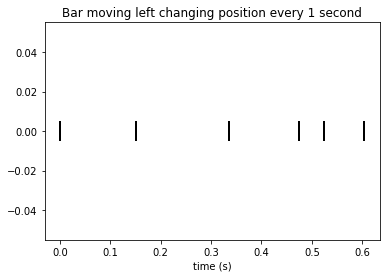

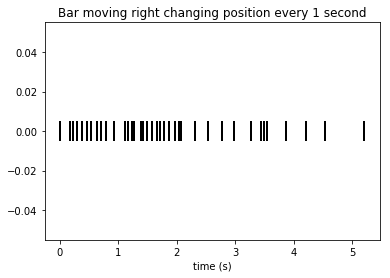

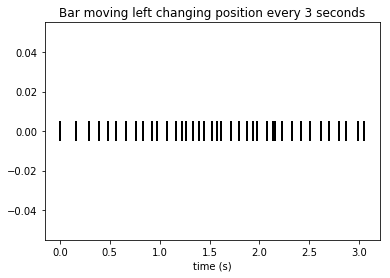

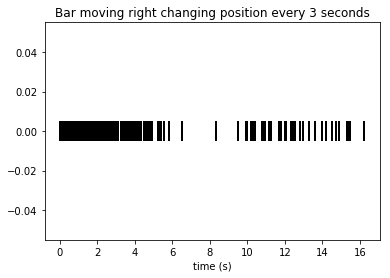

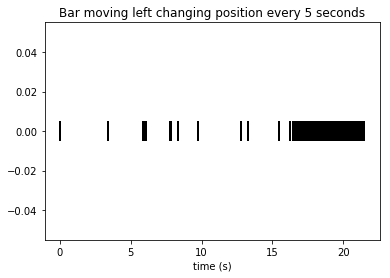

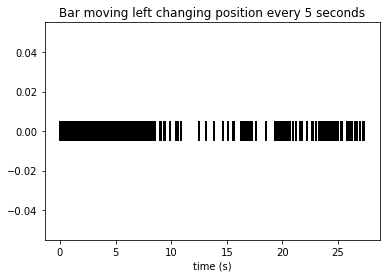

In [8]:
val = 0.

plt.clf()
fig1 = plt.figure()
left_1s = np.array(spikes_left_1s-min(spikes_left_1s))*(10**-6)
plt.plot(left_1s, np.zeros_like(left_1s) + val, '|k', mew=2, ms=20)
plt.title('Bar moving left changing position every 1 second')
plt.xlabel('time (s)')
fig1.savefig(plot_path + 'Left_1second.png', format='png', dpi=200)

fig2 = plt.figure()
right_1s = np.array(spikes_right_1s-min(spikes_right_1s))*(10**-6)
plt.plot(right_1s, np.zeros_like(right_1s) + val, '|k', mew=2, ms=20)
plt.title('Bar moving right changing position every 1 second')
plt.xlabel('time (s)')
fig2.savefig(plot_path + 'Right_1second.png', format='png', dpi=200)

fig3 = plt.figure()
left_3s = np.array(spikes_left_3s-min(spikes_left_3s))*(10**-6)
plt.plot(left_3s, np.zeros_like(left_3s) + val, '|k', mew=2, ms=20)
plt.title('Bar moving left changing position every 3 seconds')
plt.xlabel('time (s)')
fig3.savefig(plot_path + 'Left_3second.png', format='png', dpi=200)

fig4 = plt.figure()
right_3s = np.array(spikes_right_3s-min(spikes_right_3s))*(10**-6)
plt.plot(right_3s, np.zeros_like(right_3s) + val, '|k', mew=2, ms=20)
plt.title('Bar moving right changing position every 3 seconds')
plt.xlabel('time (s)')
fig4.savefig(plot_path + 'Right_3second.png', format='png', dpi=200)

fig5 = plt.figure()
left_5s = np.array(spikes_left_5s-min(spikes_left_5s))*(10**-6)
plt.plot(left_5s, np.zeros_like(left_5s) + val, '|k', mew=2, ms=20)
plt.title('Bar moving left changing position every 5 seconds')
plt.xlabel('time (s)')
fig5.savefig(plot_path + 'Left_5second.png', format='png', dpi=200)

fig6 = plt.figure()
right_5s = np.array(spikes_right_5s-min(spikes_right_5s))*(10**-6)
plt.plot(right_5s, np.zeros_like(right_5s) + val, '|k', mew=2, ms=20)
plt.title('Bar moving left changing position every 5 seconds')
plt.xlabel('time (s)')
fig6.savefig(plot_path + 'Right_5second.png', format='png', dpi=200)

plt.show()